In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import pandas as pd
import os
import cv2

import zipfile
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim

In [2]:
# Unzipping the data

# with zipfile.ZipFile('archive (5).zip', 'r') as zip_ref:
#     zip_ref.extractall()

### Reading the pictures from the directories

In [3]:
def preprocesing_image(image):
    # Gray scaling
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #
    resized_image = cv2.resize(image, (225, 225))
    # Normalizing
    normalized_image = resized_image / 255.0
    # Adding extra axis to make it compatible to deep learning models like CNN
    # normalized_img = np.expand_dims(normalized_image, axis=-1)
    return normalized_image

In [4]:
data_folder = 'brain_tumor_dataset'

# Ensure the path is valid
if os.path.exists(data_folder):
    inner_folders = ['yes', 'no']
    image_data = []

    # Loop through each inner folder
    for folder in inner_folders:
        # Get the inner folder path
        folder_path = os.path.join(data_folder, folder)

        # Get the list of files in the folder
        files = os.listdir(folder_path)

        # Create touples with image and it's label
        #labeled_images = [(os.path.join(file,), folder) for file in files]
        labeled_images = []
        for image_path in files:
            image_inner_path = os.path.join(folder, image_path)
            full_image_path = os.path.join(data_folder, image_inner_path)
            image = cv2.imread(full_image_path)
            converted_image = preprocesing_image(image)
            labeled_images.append((converted_image, folder))

        # Adding the labeled images to the main list
        image_data.extend(labeled_images)

        print(f"Folder '{folder}' contains {len(labeled_images)} images")

Folder 'yes' contains 155 images
Folder 'no' contains 98 images


In [5]:
print(len([image for image in image_data if image[1] == 'yes']))
print(len([image for image in image_data if image[1] == 'no']))

155
98



### Data Augmentation

In [6]:
# Aumentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

augmented_dir = 'brain_tumor_dataset/augmented'
os.makedirs(augmented_dir, exist_ok=True)

i = 0
for file in image_data:
    image, label = file[0], file[1]
    if label == 'no' and i <= 50:
        img_array = np.array(image)
        img_array = img_array.reshape((1,) + img_array.shape)

        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_dir,
                                  save_prefix='aug', save_format='png'):
            break
        i += 1

In [7]:
# Adding all augmented pictures to the data set

files = os.listdir(augmented_dir)

labeled_images = []
# Create tuple with image and it's label
for image_path in files:
    full_image_path = os.path.join(augmented_dir, image_path)
    image = cv2.imread(full_image_path)
    converted_image = preprocesing_image(image)
    labeled_images.append((converted_image, 'no'))

image_data.extend(labeled_images)

# Making sure it worked
len(image_data)

304

In [8]:
print(len([image for image in image_data if image[1] == 'yes']))
print(len([image for image in image_data if image[1] == 'no']))

155
149


<class 'numpy.ndarray'>


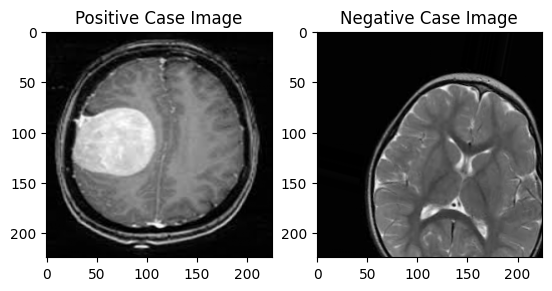

In [35]:
positive_image = image_data[0][0]  # first picture is a positive case
negative_image = image_data[-1][0]  # last case is a negative case

fix, axs = plt.subplots(1, 2)
axs[0].imshow(positive_image)
axs[0].set_title('Positive Case Image')

axs[1].imshow(negative_image)
axs[1].set_title('Negative Case Image')

print(type(image_data[0][0]))

plt.show()

##### Preprocessing image_data to a compatible type for training with pyTorch

In [38]:
# image_data is a list 0f np.ndarray

def _convert_to_uint8(image):
    # Assuming image is a float32 numpy array
    return (image * 255).astype(np.uint8)


class CustomData(Dataset):
    def __init__(self, image_data, transform=None):
        self.image_data = image_data
        self.transform = transform

        if self.transform:
            self.image_data = [(_convert_to_uint8(image), label) for image, label in self.image_data]

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, item):
        image, label = self.image_data[item]
        return image, label


In [39]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

custom_image_data = CustomData(image_data=image_data, transform=transform)

# data_loader = torch.utils.data.DataLoader(custom_image_data, batch_size=32, shuffle=True)

##### Splitting to train and validation sets

In [ ]:
# Define ratio for train and validation
train_ratio = 0.8
validation_ratio = 0.2

# Calculate number of samples for each set
total = len(custom_image_data)
train_size = int(train_ratio * total)
validation_size = total - train_size

# Create train and validation datasets
train_set, validation_set = torch.utils.data.random_split(custom_image_data, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32)

### Training RSNet
##### Using RSNet because of its excellent performance in image classification tasks

In [ ]:
# RSNet50 because of its popularity im CV tasks regarding for balance between depth and computational efficient of the model
rsnet_model = models.resnet50(pretrained=True)

In [ ]:
num_classes = 2
rsnet_model.fc = torch.nn.Linear(rsnet_model.fc.in_features, num_classes)

##### Lost function and Optimizer

In [ ]:
# Cross Entropy loss function is commonly used in image classification
criterion = torch.nn.CrossEntropyLoss()
# SGD optimizer, using lr 0.001 and momentum 0.9 as starting points
optimizer = optim.SGD(rsnet_model.parameters(), lr=0.001, momentum=0.9)

##### Training and Validating

In [ ]:
def evaluate(model, data_loader):
    """
    Evaluating model performance
    :param model: pyTorch model
    :param data_loader: data
    :return: model accuracy
    """

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            # torch.max() returns tensor where the second dimension is the predicted scores for each class
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # Setting the model to training mode
    rsnet_model.train()
    for inputs, labels in train_loader:
        # Zeroing out the gradients from previous batch so they won't influence the current batch
        optimizer.zero_grad()
        # Predicting
        outputs = rsnet_model(inputs)
        # Computing loss value
        loss = criterion(outputs, labels)
        # Backward propagating
        loss.backward()
        # Updating the model parameters based on the gradients computed during the backward pass
        optimizer.step()

    # Validating the model after each epoch
    rsnet_model.eval()
    with torch.no_grad(): # Disabling gradient computation
        for inputs, labels in validation_loader:
            outputs = rsnet_model(inputs)
            val_loss = criterion(outputs, labels)

    # Evaluate validation accuracy
    val_accuracy = evaluate(model=rsnet_model, data_loader=validation_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Val loss: {val_accuracy}")

